In [1]:
#importing necessery libraries for future analysis of the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
np.random.seed(2020)
import nltk
nltk.download('punkt') # one time execution
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read & understand your data

In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Tutorial/Personal submission")

In [3]:
data = pd.read_csv("covid19_tweets.csv")
data.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False


In [4]:
data.shape

(179108, 13)

In [5]:
data.dtypes

user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
is_retweet            bool
dtype: object

### Data cleaning

get_mention is specific to Twitter: it is getting the mention "@" item to enrich the data. 

In [6]:
twitter = True

def get_mention(txt):
    mention = []
    for i in txt.split(" "):
        if len(i) > 0 and i[0] == "@":
            mention.append(i)
    return "".join([mention[i] + ", " if i != len(mention) - 1 else mention[i] for i in range(len(mention))])

if twitter:
  data["mention"] = data.text.apply(get_mention)

Remove unsupported type like links and emails

In [7]:
def remove_link_email(txt):
    txt = txt.replace("...", "")
    txt = re.sub(r"http\S+", "", txt)
    txt = txt.replace('\S*@\S*\s?', "")
    txt = re.sub(r'[^\w\s]', '', txt)
    return txt

data.text = data.text.apply(remove_link_email)

Remove non-alphabetical characters.

In [8]:
# no non-english
def clean_non_english(txt): 
    try: 
        txt = re.sub(r'\W+', ' ', txt)
        txt = txt.lower()
        txt = txt.replace("[^a-zA-Z]", " ")
        word_tokens = word_tokenize(txt) 
        filtered_word = [w for w in word_tokens if all(ord(c) < 128 for c in w)]
        filtered_word = [w + " " for w in filtered_word]
        return "".join(filtered_word)
    except:
        return np.nan

data["english_text"] = data.text.apply(clean_non_english)

Remove stop words, which is words occuring frequently in English text but not contributing to the meaning of the text

In [9]:
# all clean
def clean_text(english_txt): 
    try: 
        word_tokens = word_tokenize(english_txt)
        filtered_word = [w for w in word_tokens if not w in stop_words] 
        filtered_word = [w + " " for w in filtered_word]
        return "".join(filtered_word)
    except:
        return np.nan

data["cleaned_text"] = data.english_text.apply(clean_text)

if your data is too large, you can randomly sample them. For the purpose of demonstration, I reduce the number of entries to 1000

In [10]:
data = data.sample(n = 1000)
data.reset_index(inplace=True)
data.drop(['index', 'source'], axis = 1, inplace=True)
print(data.shape)
data.head(3)

(1000, 15)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,is_retweet,mention,english_text,cleaned_text
0,World Health Organization Western Pacific,"Manila, Philippines",The WHO Western Pacific Region works w/ gov'ts...,2015-10-05 18:08:31,183122,1123,4703,True,2020-07-28 06:30:59,COVID19 confirmed cases and deaths in the WHO ...,['COVID19'],False,@WHO,covid19 confirmed cases and deaths in the who ...,covid19 confirmed cases deaths western pacific...
1,"David J. Ring, Jr, N1EA","Green Harbor, MA USA",n1ea@arrl.net\nFormer Radio Officer U.S. Merch...,2009-07-09 06:55:52,220,569,1761,False,2020-08-02 19:25:55,Shocking Simone Gold MD JD a practicing emerge...,['COVID19'],False,,shocking simone gold md jd a practicing emerge...,shocking simone gold md jd practicing emergenc...
2,Brother Voorhies,"Detroit, MI",DOWNLOAD MY GOSPEL SONG\nNOBODY KNOWS A FREE G...,2011-09-19 06:41:47,1114,1184,2831,False,2020-07-28 06:01:04,Everybody needs 2 RETWEET wht drstellaimmanuel...,['drstellaimmanuel'],False,,everybody needs 2 retweet wht drstellaimmanuel...,everybody needs 2 retweet wht drstellaimmanuel...


### Text data enrichment

An important feature for text is language. As we already filtered out the non-English characters, the remaining will most likely be English, Spanish, or languages using the Latin alphabet. Usually, you can run this to understand the data before preprocessing and cleaning them.

In [11]:
pip install langdetect

In [12]:
from langdetect import detect

def detect_lang(txt):
  try:
    return detect(txt)
  except:
    return np.nan

data["language"] = data.cleaned_text.apply(detect_lang)

Adding location data. Sometimes, there are locations data, which are mostly messy and unstructured. There is a package to do so: convert messy location data to structured format, which you can then filter and select your desire variable (city, states, country)

In [13]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="twitter")

def get_nation(txt):
    try: 
        if txt == "Global" or txt == "US and abroad":
            return "United States"
        location = geolocator.geocode(txt)
        x = location.address.split(",")[-1]
        while x[0] == " ":
            x = x[1:]
        if x == "United States of America":
            return "United States"
        return x
    except:
        return np.nan


data["country"] = data.user_location.apply(get_nation)

### Data understanding and exploration: visualization

We will epxlore the data via the most_common word bar graph and word cloud visualizations. 

In [14]:
!pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import datetime
from collections import Counter
import nltk
from textblob import TextBlob
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Preset code for creating word cloud for any given text

In [15]:
def word_cloud(continuous_text, name):
  mpl.rcParams['font.size']=12                #10 
  mpl.rcParams['savefig.dpi']=100             #72 
  mpl.rcParams['figure.subplot.bottom']=.1 
  print(f"word_cloud for {name}")
  stopwords = set(STOPWORDS)

  wordcloud = WordCloud(
      background_color='white',
      stopwords=stopwords,
      max_words=200,
      max_font_size=40, 
      random_state=42
      ).generate(continuous_text)

  fig = plt.figure(figsize=(12, 8))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

Most frequent bar graph for any of the given text

In [16]:
def most_frequent(text, name, top_number = 20):
  wordlist = text.split()

  wordfreq = Counter(wordlist)

  wordfreq_np = np.array(wordfreq.most_common(top_number))

  fig = plt.figure(figsize=(12,8))
  plt.bar(range(top_number), wordfreq_np.T[1][:top_number].astype('int'))
  plt.xticks(range(top_number), wordfreq_np.T[0][:top_number], rotation='vertical')
  plt.xlabel(name[-4:])
  plt.ylabel('Count')
  plt.title(f'Most frequent {name[-4:]}s of {name}')
  plt.show()

In [17]:
continuous_text = "".join(i + " " for i in data.cleaned_text)

word_cloud for wordcloud_cleaned_text


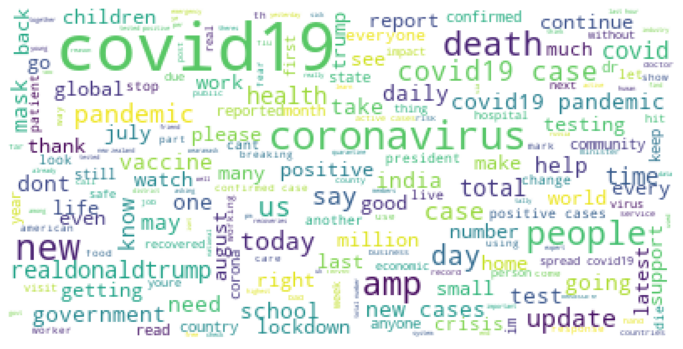

In [18]:
word_cloud(continuous_text, "wordcloud_" + "cleaned_text")

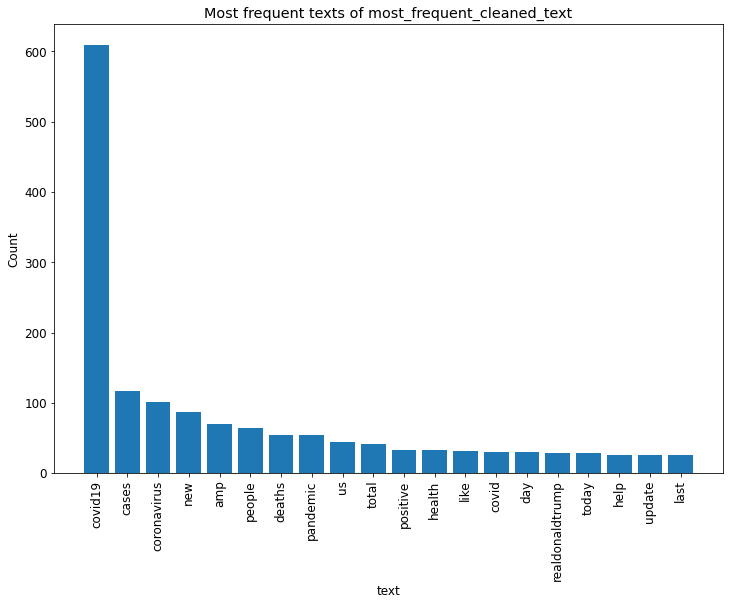

In [19]:
most_frequent(continuous_text, "most_frequent_cleaned_text")

Filter only nouns: nouns are the most informative features regarding the topic for the text. Hence, we filter the nouns with this function here using nltk Text Blob:

In [20]:
def continue_noun(txt):
  try:
    blob = TextBlob(txt).noun_phrases
    return "".join(i + " " for i in blob)
  except: 
    return np.nan

In [21]:
data['noun_phrase'] = data.cleaned_text.apply(continue_noun)
continuous_nouns = "".join(i + " " for i in data.noun_phrase)

word_cloud for wordcloud_nouns


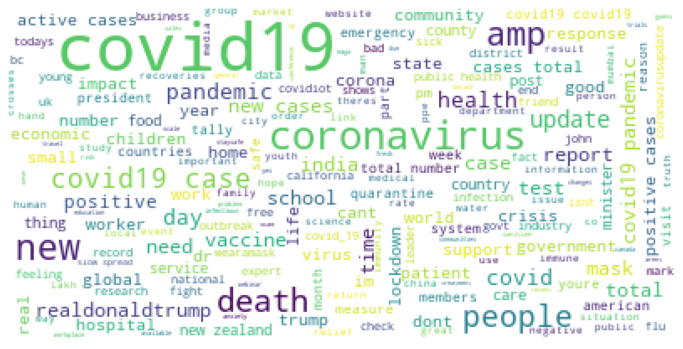

In [22]:
word_cloud(continuous_nouns, "wordcloud_" + "nouns")

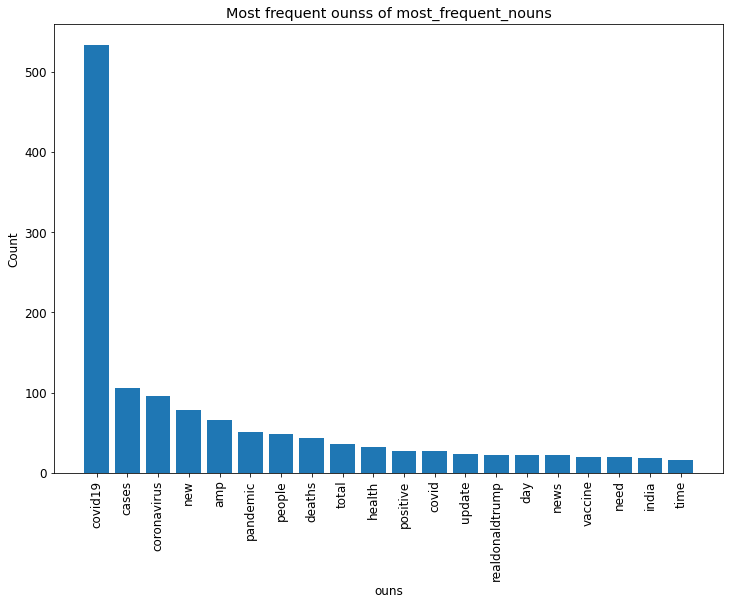

In [23]:
most_frequent(continuous_nouns, "most_frequent_" + "nouns")

Sometimes, if our data is categorical, we might want to viualize the most common of an column. Here: key1 is the key we want to understand, and key2 is any other column (for the purpose of anchoring).

In [24]:
def most_frequent_in_data(data, key1 = 'country', key2 = 'user_name', top_number = 10, size = (12,8)):
  fig = plt.figure(figsize=size)
  cur_data = data.groupby([key1]).count().reset_index()
  cur_data.sort_values(by=[key2], ascending=False, inplace=True)
  plt.bar(range(top_number), cur_data[key2][:top_number])
  plt.xticks(range(top_number), cur_data[key1][:top_number], rotation='vertical')
  plt.xlabel('Country')
  plt.ylabel('Count')
  plt.title(f'Most posted tweet from countries')
  plt.show()

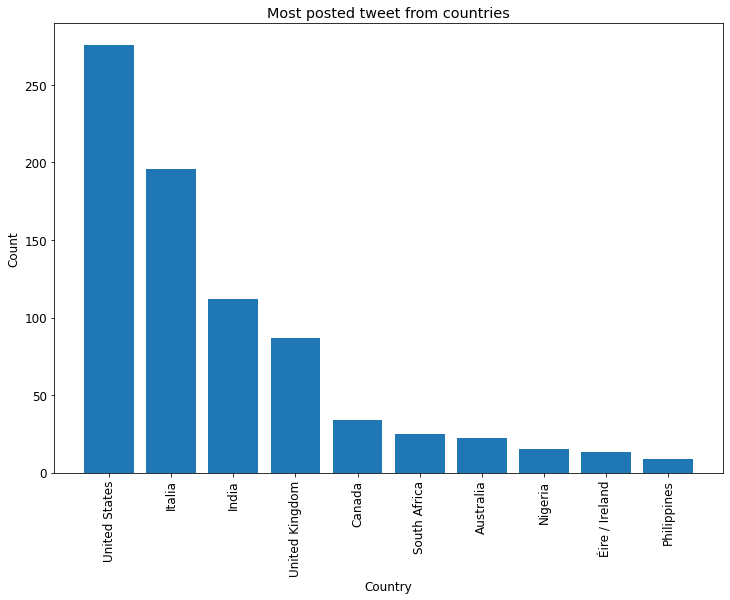

In [25]:
most_frequent_in_data(data)

Hope you find these codes useful. It works for any dataset, as long as you follow the naming scheme accrodingly, and you shall be good. Hope you can clean, prepare, and understand you data more!